In [16]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from abstract import ForecastingMethod
from linear_regression import LinearRegression

# Linear Regression

R^2 Score: -0.18890047249166608
Loss (MSE): 10.255737984943288


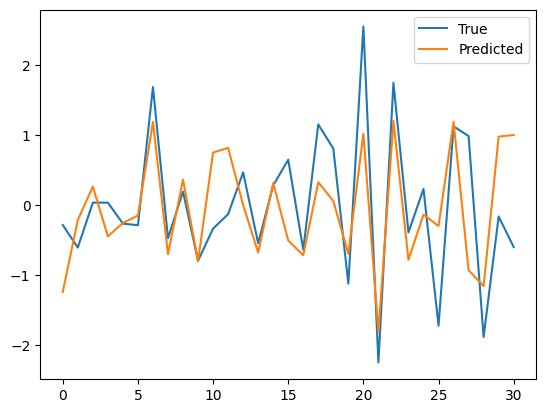

R^2 Score: -0.34161362508705073
Loss (MSE): 11.573077927277195


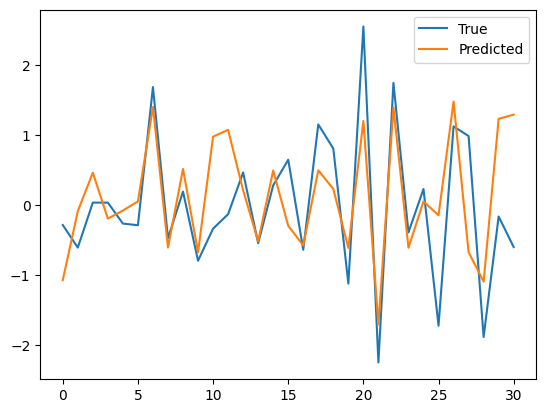

R^2 Score: -0.040637078400798554
Loss (MSE): 8.976782716831066


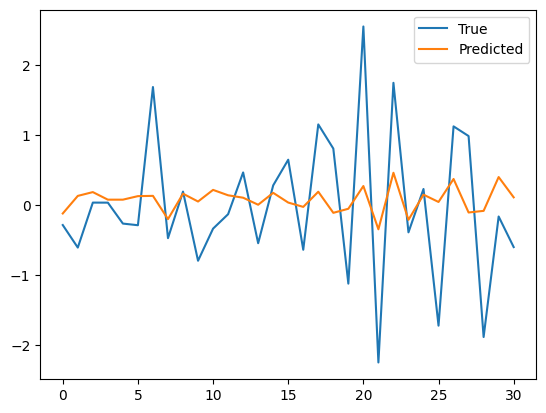

R^2 Score: -0.14468969587489933
Loss (MSE): 9.87436532038192


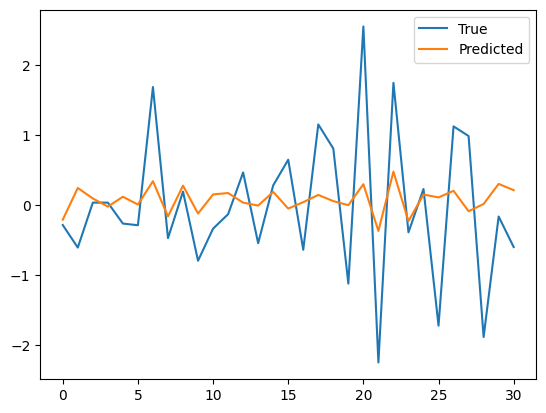

In [17]:
X, y = ForecastingMethod.load_data("../data/paper-data.csv")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

models = [
    LinearRegression(regularization=None, fit_intercept=False, cv_folds=None),
    LinearRegression(regularization=None, fit_intercept=True, cv_folds=None),
    LinearRegression(
        regularization="l1", fit_intercept=True, cv_folds=5, alphas=[0.1, 0.5]
    ),
    LinearRegression(
        regularization="l2",
        fit_intercept=True,
        cv_folds=5,
        alphas=[0.1, 0.5, 1, 5, 10, 100],
    ),
]
for model in models:
    model.train(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"R^2 Score: {model.score(X_test, y_test)}")
    print(f"Loss (MSE): {((y_test - y_pred)**2).sum()}")

    x_axis_train = np.linspace(0, len(y_train), len(y_train), endpoint=False)
    x_axis_test = np.linspace(
        len(y_train), len(y_train) + len(y_test), len(y_test), endpoint=False
    )
    plt.plot(np.concatenate((x_axis_train, x_axis_test)), y, label="True")
    plt.plot(
        np.concatenate((x_axis_train, x_axis_test)),
        model.predict(X),
        label="Predicted",
    )
    plt.legend()
    plt.show()